Code to analyze Tim O's Shape task.

By Tiffany 

August 2024

In [55]:
#import necessary libraries
import sys
import os
sys.path.append('../scripts')
import glob
import core_parse as cp
# Codes used to analyze certain mworks files used in object recognition experiments

import re
import numpy as np
import nmObjTest as nm #library that Manu created to extract info from Najib's object tasks
#Need to see if the above library will


import importlib
import pandas as pd
importlib.reload(nm)

import matplotlib.pyplot as plt



Get the file name and ensure it exists

In [56]:
#replace the file name with desired file
filename_mwk2 = 'AA_beh_Shapes_Cat2_bg_refresh_jf8_240821.mwk2'

#where are the mwk2 files located?
mwk2_filedir = '/v/awake_A2L/AA/mwk/'
exfile_filepath = os.path.join(mwk2_filedir,filename_mwk2)
if os.path.isfile(exfile_filepath):
    print('file exists')
else:
    print('Cannot find file, are you sure it is there?')

file exists


In [57]:
#just need enough codes to figure out what choices the animal made, whether it was successful or not, and what time the success and failure were logged as this is a flag of reaction time.
relevant_codes_to_grab = ['#announceMessage','#stimDisplayUpdate','trial_bounds','target_angle','choice_locations','success','failure','oddity_category_index','distractor_category_index']

parsed_file,_ = cp.parse_mwk2(exfile_filepath, codes = relevant_codes_to_grab)


In [58]:
display(pd.DataFrame(parsed_file))

,code,times,info
0,#announceMessage,"[6219567975839, 6219567976017, 6219567983212, ...","[0, {'domain': 8, 'message': 'Opened data file..."
1,#stimDisplayUpdate,"[6219567975840, 6219567984256, 6219572403284, ...","[[], [], [], [{'center_y': 0.0, 'width': 10.0,..."
2,trial_bounds,"[6219567975957, 6219567984480, 6219572403573, ...","[[-1, -1], [-1, -1], [-1, -1], [-1, -1], [6219..."
3,target_angle,"[6219567975960, 6219567984484, 6219572403577, ...","[0, 0, 0, 45, 225, 315, 315, 225, 45, 135, 135..."
4,choice_locations,"[6219567975946, 6219567984439, 6219572403553, ...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, ..."
5,success,"[6219567975953, 6219567984450, 6219572403566, ...","[0, 0, 0, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11..."
6,failure,"[6219567975952, 6219567984449, 6219572403565, ...","[0, 0, 0, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11..."
7,oddity_category_index,"[6219567975902, 6219567984358, 6219572403404, ...","[1, 1, 1, 1, 4, 8, 2, 3, 7, 7, 3, 5, 8, 6, 0, ..."
8,distractor_category_index,"[6219567975903, 6219567984359, 6219572403406, ...","[1, 1, 1, 3, 9, 0, 8, 5, 6, 9, 8, 1, 0, 3, 3, ..."


Extract start and stop time for each trial

In [59]:
#step 1 get start and stop times of each trial

def extract_simple(parsed_file,code):
    dict = [x for x in parsed_file if code in str(x["code"])][0]
    times = np.asarray(dict["times"])
    values = np.asarray(dict["info"], dtype=object)
    return times,values
times,values = extract_simple(parsed_file,'trial_bounds')

#find values where start and stop are filled in with not -1s, those delimit completed trials
trial_start = [x[0] for index,x in enumerate(values) if np.logical_and(x[0]!=-1,x[1]!=-1)]
trial_end = [x[1] for index,x in enumerate(values) if np.logical_and(x[0]!=-1,x[1]!=-1)]

#step 2, figure out which trials were successful and which were not successful.
success_times,_ = extract_simple(parsed_file,'success')
failure_times,_ = extract_simple(parsed_file,'failure')

outcome = -1*np.ones(np.shape(trial_start))
outcome_time = -1*np.ones(np.shape(trial_start))
for index,(start,end) in enumerate(zip(trial_start,trial_end)):
    if np.any(np.logical_and(success_times>start,success_times<end)):
        outcome[index] = 1
        outcome_time[index] = success_times[np.logical_and(success_times>start,success_times<end)][0]
    elif np.any(np.logical_and(failure_times>start,failure_times<end)): 
        outcome[index] = 0
        outcome_time[index] = failure_times[np.logical_and(failure_times>start,failure_times<end)][0]

In [60]:
#step 3, find which targets were looked at on successful and unsuccessful trials

#step 3a, find the angle of the target on each trial
target = -1*np.ones(np.shape(trial_start))
targ_time,targ_val = extract_simple(parsed_file,'target_angle')
for index,(start,end) in enumerate(zip(trial_start,trial_end)):
    if np.any(np.logical_and(targ_time>start,targ_time<end)):
        tmp = targ_val[np.logical_and(targ_time>start,targ_time<end)]
        target[index] = tmp[0]


The value array for choice locations are all of varying sizes.
- need to pad the array so the shape is 11.

In [61]:
#step 3b, filter out all instances were all values are 0
times,values = extract_simple(parsed_file,'choice_locations')
filtered_values = [y for x, y in zip(times, values) if ~np.all(y == 0)]
max_len = max(len(y) for y in filtered_values) #should be 11, all will be padded to 11
padded_values = np.array([np.pad(y, (0, max_len - len(y)), mode='constant', constant_values=0) 
                          for y in filtered_values], dtype=object)
mask = np.array([not all(x == 0 for x in lst) for lst in padded_values]) #bool mask to grab the needed incides
times_sub = times[mask]
values_sub = values[mask]
choice = target.copy()

In [62]:
print(len(times_sub))
print(len(values_sub))
#checking to see if the lengths are the same

4683
4683


In [63]:
        
#step 3c, go through start and end of each trial and figure out what choice the animal made on each trial
for index,(start,end) in enumerate(zip(trial_start,trial_end)):
    if np.any(np.logical_and(times_sub>start,times_sub<end)):
        vals_unpad = values_sub[np.logical_and(times_sub>start,times_sub<end)]
        vals = np.array([np.pad(y, (0, max_len - len(y)), mode='constant', constant_values=0) 
                          for y in vals_unpad], dtype=object)
        vals2 = [x[np.logical_and(x!=0,x!=-1)] for x in vals]
        
        
        vals3 = [x for x in vals2 if any(x)]
        # if any(vals3):
        #     vals3 = np.ndarray.flatten(np.asarray(vals3))
        #     choice[index] = vals3[-1] #take the last choice as the one the animal made


need to extract oddity and distractor category information

In [64]:
oddity = -1*np.ones(np.shape(trial_start))
oddity_timing,oddity_index= extract_simple(parsed_file, 'oddity_category_index')
for index,(start,end) in enumerate(zip(trial_start,trial_end)):
    if np.any(np.logical_and(oddity_timing>start,oddity_timing<end)):
        tmp = oddity_index[np.logical_and(oddity_timing>start,oddity_timing<end)]
        oddity[index] = tmp[0] +1 # need to add one since index 0
        
distractor = -1*np.ones(np.shape(trial_start))
distractor_timing,distractor_index = extract_simple(parsed_file, 'distractor_category_index')
for index,(start,end) in enumerate(zip(trial_start,trial_end)):
    if np.any(np.logical_and(distractor_timing>start,distractor_timing<end)):
        tmp = distractor_index[np.logical_and(distractor_timing>start,distractor_timing<end)]
        distractor[index] = tmp[0]+1


Going to get file names for images and the time at which things appeard on the screen

In [65]:
#our goal is to get filenames for images that are shown, the time at which things appeared on screen, and finally 
stim_times,stim_vals = extract_simple(parsed_file,'#stimDisplayUpdate')

file_store = []
angle_store = []
stim_on_time = -1*np.ones(np.shape(trial_start))
for index,(start,end) in enumerate(zip(trial_start,trial_end)):

    #find times the stimulus on screen was updated during the trial
    curr_trial_times = stim_times[np.logical_and(stim_times>start,stim_times<end)] 
    curr_trial_stim = stim_vals[np.logical_and(stim_times>start,stim_times<end)]
    
    # find the instances most stuff was drawn to the screen and extract the stim and onset_time for that
    lens_disp = np.asarray([len(x) for x in curr_trial_stim])
    stim = curr_trial_stim[np.argmax(lens_disp)]
    onset_time = curr_trial_times[np.argmax(lens_disp)]
    stim_on_time[index] = onset_time
    #get file parameters
    stim2 = [x for x in stim if 'filename' in x]
    filenames = [x['filename'].split('/')[-1] for x in stim2]
    angles = [180*(1/np.pi)*np.arctan2(x['pos_y'],x['pos_x']) for x in stim2]
    angles2 = np.asarray([x if x>0 else x+360 for x in angles])

    #store everything
    file_store.append(filenames)
    angle_store.append(angles2)

In [66]:
print(outcome)

[1. 1. 0. ... 1. 1. 1.]


In [67]:
print(len(target))
print(len(choice))
print(len(outcome))
print(len(oddity))
print(len(distractor))

1397
1397
1397
1397
1397


In [68]:
stats = pd.DataFrame({'target':target,'choice':choice,'outcome':outcome,'oddity index':oddity,'distractor index':distractor})

In [69]:
display(stats)

,target,choice,outcome,oddity index,distractor index
0,45.0,45.0,1.0,2.0,4.0
1,225.0,225.0,1.0,5.0,10.0
2,315.0,315.0,0.0,9.0,1.0
3,315.0,315.0,0.0,3.0,9.0
4,225.0,225.0,0.0,4.0,6.0
...,...,...,...,...,...
1392,45.0,45.0,1.0,8.0,4.0
1393,225.0,225.0,1.0,1.0,8.0
1394,315.0,315.0,1.0,2.0,10.0
1395,135.0,135.0,1.0,4.0,8.0


Need to group all the trials by stimulus oddity category- to all the creation of a nested dictionary

In [70]:
by_oddity_category = stats.groupby('oddity index')
categories = by_oddity_category['oddity index'].unique()
display(categories)

oddity index
1.0      [1.0]
2.0      [2.0]
3.0      [3.0]
4.0      [4.0]
5.0      [5.0]
6.0      [6.0]
7.0      [7.0]
8.0      [8.0]
9.0      [9.0]
10.0    [10.0]
Name: oddity index, dtype: object

In [71]:
#this is the nesting and it does go through each distractor for each stimulus and get the percent correct and store it
stim_dict = {}  # Create an empty dictionary

# Step 1: Extract all unique distractor indices (as a list)
all_distractor_indices = by_oddity_category['distractor index'].unique()
# For each stimulus oddity category, go in and split it by distractor groups
for stim_name, stim_data in by_oddity_category:
    distractor_groups = stim_data.groupby('distractor index')
    stim_dict[stim_name] = {}  # Creating a nested dictionary

    if stim_name == 1.0:
        stim_dict[stim_name][1.0] = np.nan
        
    for distractor_name, distractor_data in distractor_groups:
        outcomes = distractor_data['outcome']
        non_aborted_outcomes = outcomes[outcomes != -1] 
        #this ensures that the percent correct is taken from all non aborted trials
        mean_outcome = non_aborted_outcomes.mean()
        stim_dict[stim_name][distractor_name] = mean_outcome

total_trials = (stats['outcome'] != -1).sum()

In [72]:
print(total_trials)

1291


In [73]:
display(stim_dict) #for viewing purposes

{1.0: {1.0: nan,
  2.0: 1.0,
  3.0: 1.0,
  4.0: 1.0,
  5.0: 0.8333333333333334,
  6.0: 1.0,
  7.0: 0.8888888888888888,
  8.0: 0.9444444444444444,
  9.0: 0.9444444444444444,
  10.0: 1.0},
 2.0: {1.0: 1.0,
  3.0: 0.8333333333333334,
  4.0: 0.9333333333333333,
  5.0: 0.9333333333333333,
  6.0: 0.9090909090909091,
  7.0: 1.0,
  8.0: 0.8571428571428571,
  9.0: 1.0,
  10.0: 1.0},
 3.0: {1.0: 1.0,
  2.0: 0.9166666666666666,
  4.0: 1.0,
  5.0: 1.0,
  6.0: 0.8461538461538461,
  7.0: 0.9333333333333333,
  8.0: 0.8571428571428571,
  9.0: 0.8421052631578947,
  10.0: 0.9375},
 4.0: {1.0: 1.0,
  2.0: 0.7692307692307693,
  3.0: 0.8,
  5.0: 0.9444444444444444,
  6.0: 0.8125,
  7.0: 0.9411764705882353,
  8.0: 0.75,
  9.0: 0.7272727272727273,
  10.0: 1.0},
 5.0: {1.0: 1.0,
  2.0: 0.8666666666666667,
  3.0: 0.9545454545454546,
  4.0: 0.8,
  6.0: 0.8095238095238095,
  7.0: 0.9473684210526315,
  8.0: 1.0,
  9.0: 0.8125,
  10.0: 0.8},
 6.0: {1.0: 1.0,
  2.0: 0.7692307692307693,
  3.0: 0.6923076923076923,
  


## Plotting code for one figure for all categories

I need a double nested dictionary, a category dictionary- that will hold the stim dict of each category

#### List of file names

In [74]:
#gather list of file names
total_files = ['AA_beh_Shapes_Cat1_240604.mwk2', 'AA_beh_Shapes_Cat2_240611.mwk2', 'AA_beh_Shapes_Cat4_240530.mwk2']

#total_files = ['AA_beh_Shapes_Cat1_bg_refresh_240711.mwk2', 'AA_beh_Shapes_Cat2_bg_refresh_240614.mwk2', 'AA_beh_Shapes_Cat4_bg_refresh_240621.mwk2']


#total_files = ['AA_beh_Shapes_Cat1_bg_refresh_jf8_240820.mwk2', 'AA_beh_Shapes_Cat2_bg_refresh_jf8_240821.mwk2', 'AA_beh_Shapes_Cat4_bg_refresh_jf8_240822.mwk2']

#total_files = ['AA_beh_Shapes_Cat1_bg_refresh_jf16_240903.mwk2', 'AA_beh_Shapes_Cat2_bg_refresh_jf16_240904.mwk2', 'AA_beh_Shapes_Cat4_bg_refresh_jf16_240905.mwk2']




loop to extract info from each file in the list and add it to cat_dict

In [75]:
import re
import seaborn as sns

cat_dict = {}#nested dict, values will be stim dicts.
list_filename = []
for file in total_files:
    filename_mwk2 = file
    list_filename.append(filename_mwk2)
    #check that the file exists
    mwk2_filedir = '/v/awake_A2L/AA/mwk/'
    exfile_filepath = os.path.join(mwk2_filedir,filename_mwk2)
    if os.path.isfile(exfile_filepath):
        print(f'file exists {filename_mwk2}')
    else:
        print(f'Cannot find file {filename_mwk2}, are you sure it is there?')

    #extract the category number
    pattern = r"Cat(\d+)"
    match = re.search(pattern, filename_mwk2)
    shape_category = match.group(1)
    print(f'category: {shape_category}')

    relevant_codes_to_grab = ['#announceMessage','#stimDisplayUpdate','trial_bounds','target_angle','choice_locations','success','failure','oddity_category_index','distractor_category_index']
    parsed_file,_ = cp.parse_mwk2(exfile_filepath, codes = relevant_codes_to_grab)

    def extract_simple(parsed_file,code):
        dict = [x for x in parsed_file if code in str(x["code"])][0]
        times = np.asarray(dict["times"])
        values = np.asarray(dict["info"], dtype=object)
        return times,values
    times,values = extract_simple(parsed_file,'trial_bounds')

    #find values where start and stop are filled in with not -1s, those delimit completed trials
    trial_start = [x[0] for index,x in enumerate(values) if np.logical_and(x[0]!=-1,x[1]!=-1)]
    trial_end = [x[1] for index,x in enumerate(values) if np.logical_and(x[0]!=-1,x[1]!=-1)]

    #step 2, figure out which trials were successful and which were not successful.
    success_times,_ = extract_simple(parsed_file,'success')
    failure_times,_ = extract_simple(parsed_file,'failure')

    outcome = -1*np.ones(np.shape(trial_start))
    outcome_time = -1*np.ones(np.shape(trial_start))
    for index,(start,end) in enumerate(zip(trial_start,trial_end)):
        if np.any(np.logical_and(success_times>start,success_times<end)):
            outcome[index] = 1
            outcome_time[index] = success_times[np.logical_and(success_times>start,success_times<end)][0]
        elif np.any(np.logical_and(failure_times>start,failure_times<end)): 
            outcome[index] = 0
            outcome_time[index] = failure_times[np.logical_and(failure_times>start,failure_times<end)][0]
    #step 3, find which targets were looked at on successful and unsuccessful trials

    #step 3a, find the angle of the target on each trial
    target = -1*np.ones(np.shape(trial_start))
    targ_time,targ_val = extract_simple(parsed_file,'target_angle')
    for index,(start,end) in enumerate(zip(trial_start,trial_end)):
        if np.any(np.logical_and(targ_time>start,targ_time<end)):
            tmp = targ_val[np.logical_and(targ_time>start,targ_time<end)]
            target[index] = tmp[0]
    #step 3b, filter out all instances were all values are 0
    times,values = extract_simple(parsed_file,'choice_locations')
    filtered_values = [y for x, y in zip(times, values) if ~np.all(y == 0)]
    max_len = max(len(y) for y in filtered_values) #should be 11, all will be padded to 11
    padded_values = np.array([np.pad(y, (0, max_len - len(y)), mode='constant', constant_values=0) 
                          for y in filtered_values], dtype=object)
    mask = np.array([not all(x == 0 for x in lst) for lst in padded_values]) #bool mask to grab the needed incides
    times_sub = times[mask]
    values_sub = values[mask]
    choice = target.copy()
    for index,(start,end) in enumerate(zip(trial_start,trial_end)):
        if np.any(np.logical_and(times_sub>start,times_sub<end)):
            vals_unpad = values_sub[np.logical_and(times_sub>start,times_sub<end)]
            vals = np.array([np.pad(y, (0, max_len - len(y)), mode='constant', constant_values=0) 
                          for y in vals_unpad], dtype=object)
            vals2 = [x[np.logical_and(x!=0,x!=-1)] for x in vals]
        
        
            vals3 = [x for x in vals2 if any(x)]
    oddity = -1*np.ones(np.shape(trial_start))
    oddity_timing,oddity_index= extract_simple(parsed_file, 'oddity_category_index')
    for index,(start,end) in enumerate(zip(trial_start,trial_end)):
        if np.any(np.logical_and(oddity_timing>start,oddity_timing<end)):
            tmp = oddity_index[np.logical_and(oddity_timing>start,oddity_timing<end)]
            oddity[index] = tmp[0] +1 # need to add one since index 0
        
    distractor = -1*np.ones(np.shape(trial_start))
    distractor_timing,distractor_index = extract_simple(parsed_file, 'distractor_category_index')
    for index,(start,end) in enumerate(zip(trial_start,trial_end)):
        if np.any(np.logical_and(distractor_timing>start,distractor_timing<end)):
            tmp = distractor_index[np.logical_and(distractor_timing>start,distractor_timing<end)]
            distractor[index] = tmp[0]+1
 
    #our goal is to get filenames for images that are shown, the time at which things appeared on screen, and finally 
    stim_times,stim_vals = extract_simple(parsed_file,'#stimDisplayUpdate')

    file_store = []
    angle_store = []
    stim_on_time = -1*np.ones(np.shape(trial_start))
    for index,(start,end) in enumerate(zip(trial_start,trial_end)):

        #find times the stimulus on screen was updated during the trial
        curr_trial_times = stim_times[np.logical_and(stim_times>start,stim_times<end)] 
        curr_trial_stim = stim_vals[np.logical_and(stim_times>start,stim_times<end)]
    
        # find the instances most stuff was drawn to the screen and extract the stim and onset_time for that
        lens_disp = np.asarray([len(x) for x in curr_trial_stim])
        stim = curr_trial_stim[np.argmax(lens_disp)]
        onset_time = curr_trial_times[np.argmax(lens_disp)]
        stim_on_time[index] = onset_time
        #get file parameters
        stim2 = [x for x in stim if 'filename' in x]
        filenames = [x['filename'].split('/')[-1] for x in stim2]
        angles = [180*(1/np.pi)*np.arctan2(x['pos_y'],x['pos_x']) for x in stim2]
        angles2 = np.asarray([x if x>0 else x+360 for x in angles])

        #store everything
        file_store.append(filenames)
        angle_store.append(angles2)

    stats = pd.DataFrame({'target':target,'choice':choice,'outcome':outcome,'oddity index':oddity,'distractor index':distractor})

    by_oddity_category = stats.groupby('oddity index')
    categories = by_oddity_category['oddity index'].unique()

    stim_dict = {}  # Create an empty dictionary

    # Step 1: Extract all unique distractor indices (as a list)
    all_distractor_indices = by_oddity_category['distractor index'].unique()
    # For each stimulus oddity category, go in and split it by distractor groups
    for stim_name, stim_data in by_oddity_category:
        distractor_groups = stim_data.groupby('distractor index')
        stim_dict[stim_name] = {}  # Creating a nested dictionary

        if stim_name == 1.0:
            stim_dict[stim_name][1.0] = np.nan
        
        for distractor_name, distractor_data in distractor_groups:
            outcomes = distractor_data['outcome']
            non_aborted_outcomes = outcomes[outcomes != -1] 
            #this ensures that the percent correct is taken from all non aborted trials
            mean_outcome = non_aborted_outcomes.mean()
            stim_dict[stim_name][distractor_name] = mean_outcome

    total_trials = (stats['outcome'] != -1).sum()
    cat_dict[shape_category] = stim_dict
    

file exists AA_beh_Shapes_Cat1_240604.mwk2
category: 1
file exists AA_beh_Shapes_Cat2_240611.mwk2
category: 2
file exists AA_beh_Shapes_Cat4_240530.mwk2
category: 4


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


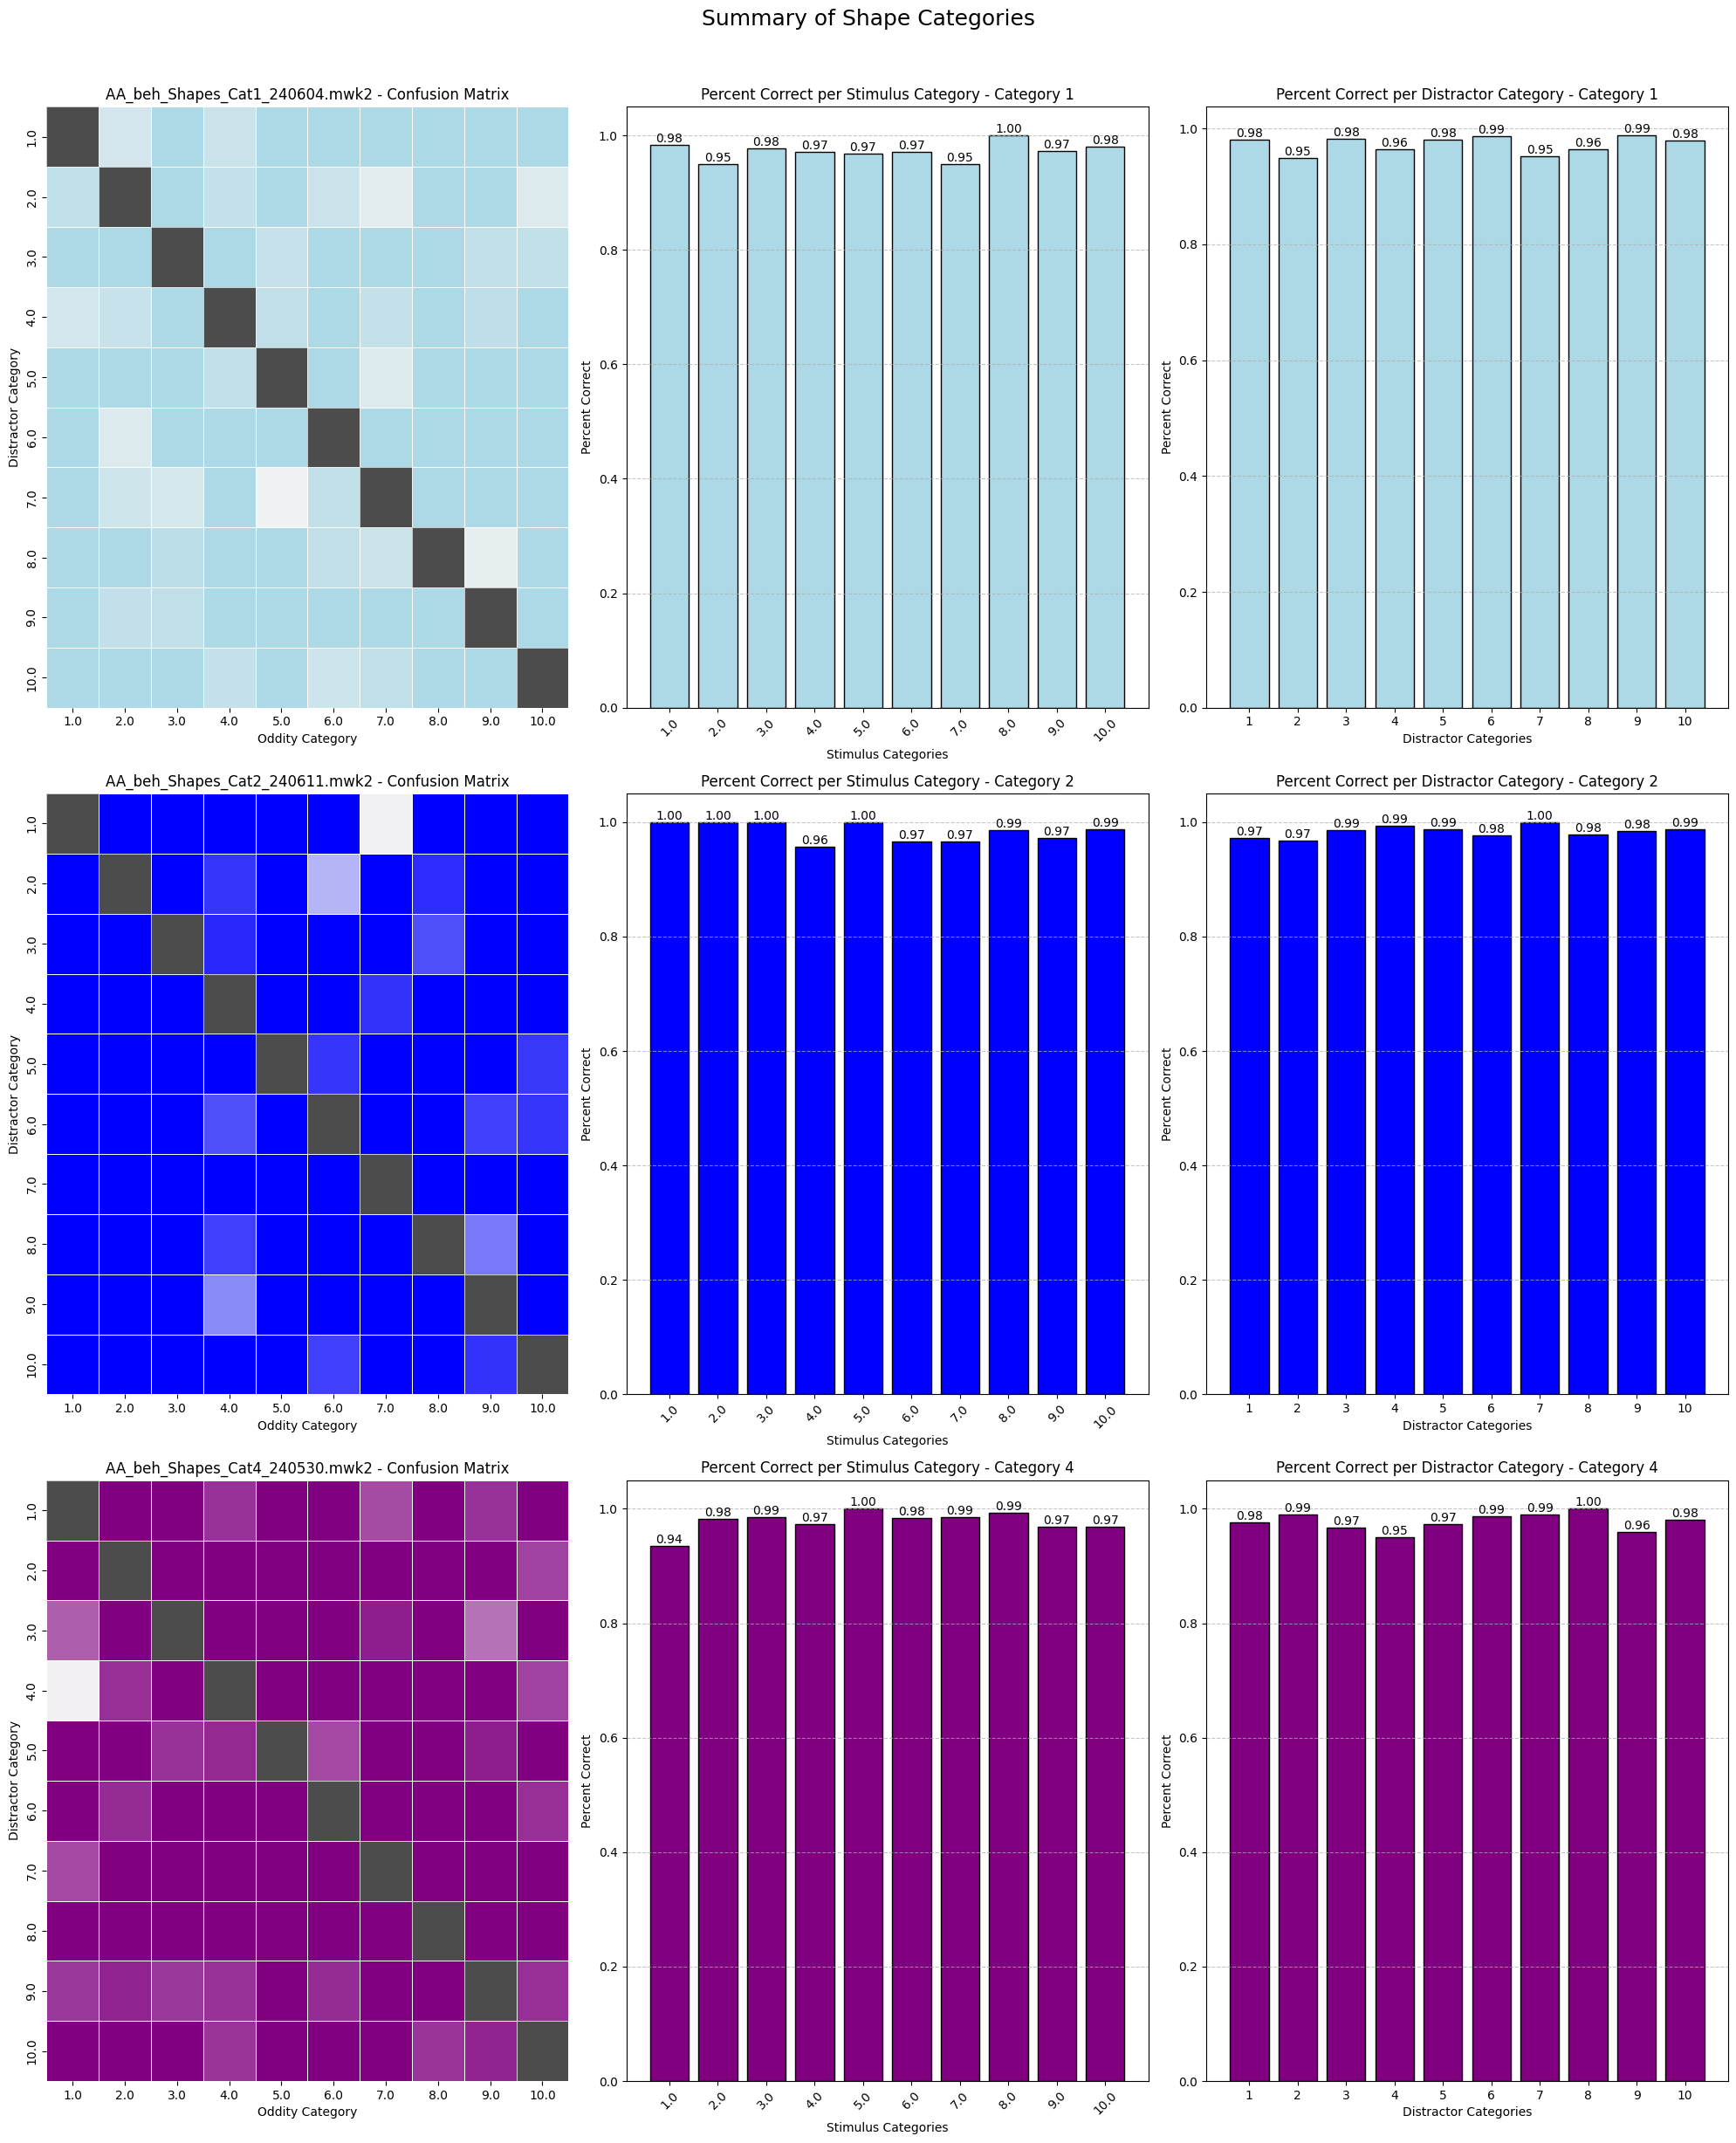

In [81]:
import matplotlib.colors as mcolors


fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 25))  # Adjust figure size as needed
row_colors = ['lightblue', 'blue', 'purple', 'green']
# Loop over each category and plot in the respective row
for i,(key, value) in enumerate(cat_dict.items()):
    # Create a DataFrame for the current category (assume stim_dict is organized by category)
    df = pd.DataFrame(value)  # Modify this based on your data structure

    ## CONFUSION MATRIX PLOT ******************************
    mask = df.isna()
    heatmap_color = sns.light_palette(row_colors[i], as_cmap=True)

    #cmap = sns.color_palette(row_colors[i], as_cmap=True)

    # Plot the heatmap on the first column (i-th row, first column)
    sns.heatmap(df, annot=False, cmap=heatmap_color, fmt=".2f", linewidths=.5, mask=mask, cbar=False, ax=axes[i, 0])

    # Overlay the NaN cells with black
    sns.heatmap(mask, mask=~mask, cmap=['black'], cbar=False, linewidths=.5, ax=axes[i, 0], alpha=0.7)

    # Set titles and labels for the confusion matrix
    axes[i, 0].set_title(f'{list_filename[i]} - Confusion Matrix')
    axes[i, 0].set_xlabel('Oddity Category')
    axes[i, 0].set_ylabel('Distractor Category')

    ## MARGINAL 1 STIMULUS PLOT ******************************
    oddity_avg = df.mean(axis=0)
    x_labels = oddity_avg.index.astype(str)

    # Plot the averages as a bar graph on the second column (i-th row, second column)
    bars = axes[i, 1].bar(x_labels, oddity_avg, color=row_colors[i], edgecolor='black')

    # Add labels at the top of each bar
    for bar in bars:
        yval = bar.get_height()
        axes[i, 1].text(bar.get_x() + bar.get_width() / 2, yval, f'{yval:.2f}', ha='center', va='bottom', color='black')

    axes[i, 1].set_xlabel('Stimulus Categories')
    axes[i, 1].set_ylabel('Percent Correct')
    axes[i, 1].set_title(f'Percent Correct per Stimulus Category - Category {key}')
    axes[i, 1].grid(axis='y', linestyle='--', alpha=0.7)
    axes[i, 1].tick_params(axis='x', rotation=45)

    ## MARGINAL 2 DISTRACTOR PLOT ******************************
    df['distractorAvg'] = df.mean(axis=1)

    # Plot the averages as a bar graph on the third column (i-th row, third column)
    bars = axes[i, 2].bar(df.index, df['distractorAvg'], color=row_colors[i], edgecolor='black')

    for bar in bars:
        yval = bar.get_height()
        axes[i, 2].text(bar.get_x() + bar.get_width() / 2, yval, f'{yval:.2f}', ha='center', va='bottom', color='black')

    axes[i, 2].set_xlabel('Distractor Categories')
    axes[i, 2].set_ylabel('Percent Correct')
    axes[i, 2].set_title(f'Percent Correct per Distractor Category - Category {key}')
    axes[i, 2].grid(axis='y', linestyle='--', alpha=0.7)
    axes[i, 2].set_xticks(df.index)

# Adjust layout to prevent overlap and display the full figure
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout with space for suptitle
plt.suptitle('Summary of Shape Categories', fontsize=18)
fig = plt.gcf() 
plt.savefig('/home/tiffany/mwk_behavior/notebooks/figures/AA_summary_performance.eps', format='eps')
plt.show()

#### Code to Extract Timing

In [77]:
rt = [(x-y)/1000 if x!=-1 else -1 for x,y in zip(outcome_time,stim_on_time)]
times_stats = pd.DataFrame({'target':target,'choice':choice,'outcome':outcome,'oddity index':oddity,'distractor index':distractor})
times_stats['rt'] = rt
display(times_stats)

,target,choice,outcome,oddity index,distractor index,rt
0,225.0,225.0,-1.0,8.0,4.0,-1.000
1,135.0,135.0,1.0,6.0,7.0,583.778
2,315.0,315.0,1.0,1.0,2.0,1381.303
3,135.0,135.0,1.0,2.0,9.0,1175.987
4,315.0,315.0,1.0,8.0,1.0,593.935
...,...,...,...,...,...,...
1591,315.0,315.0,1.0,5.0,10.0,552.238
1592,45.0,45.0,1.0,7.0,6.0,661.171
1593,225.0,225.0,1.0,5.0,4.0,604.909
1594,225.0,225.0,1.0,2.0,5.0,558.109


Adding the timing code into the above code

In [78]:
import re

cat_dict = {}#nested dict, values will be stim dicts.
cat_dict_times = {} #nested dict, values will be stim dict times
list_filename = []
for file in total_files:
    filename_mwk2 = file
    list_filename.append(filename_mwk2)
    #check that the file exists
    mwk2_filedir = '/v/awake_A2L/AA/mwk/'
    exfile_filepath = os.path.join(mwk2_filedir,filename_mwk2)
    if os.path.isfile(exfile_filepath):
        print(f'file exists {filename_mwk2}')
    else:
        print(f'Cannot find file {filename_mwk2}, are you sure it is there?')

    #extract the category number
    pattern = r"Cat(\d+)"
    match = re.search(pattern, filename_mwk2)
    shape_category = match.group(1)
    print(f'category: {shape_category}')

    relevant_codes_to_grab = ['#announceMessage','#stimDisplayUpdate','trial_bounds','target_angle','choice_locations','success','failure','oddity_category_index','distractor_category_index']
    parsed_file,_ = cp.parse_mwk2(exfile_filepath, codes = relevant_codes_to_grab)

    def extract_simple(parsed_file,code):
        dict = [x for x in parsed_file if code in str(x["code"])][0]
        times = np.asarray(dict["times"])
        values = np.asarray(dict["info"], dtype=object)
        return times,values
    times,values = extract_simple(parsed_file,'trial_bounds')

    #find values where start and stop are filled in with not -1s, those delimit completed trials
    trial_start = [x[0] for index,x in enumerate(values) if np.logical_and(x[0]!=-1,x[1]!=-1)]
    trial_end = [x[1] for index,x in enumerate(values) if np.logical_and(x[0]!=-1,x[1]!=-1)]

    #step 2, figure out which trials were successful and which were not successful.
    success_times,_ = extract_simple(parsed_file,'success')
    failure_times,_ = extract_simple(parsed_file,'failure')

    outcome = -1*np.ones(np.shape(trial_start))
    outcome_time = -1*np.ones(np.shape(trial_start))
    for index,(start,end) in enumerate(zip(trial_start,trial_end)):
        if np.any(np.logical_and(success_times>start,success_times<end)):
            outcome[index] = 1
            outcome_time[index] = success_times[np.logical_and(success_times>start,success_times<end)][0]
        elif np.any(np.logical_and(failure_times>start,failure_times<end)): 
            outcome[index] = 0
            outcome_time[index] = failure_times[np.logical_and(failure_times>start,failure_times<end)][0]
    #step 3, find which targets were looked at on successful and unsuccessful trials

    #step 3a, find the angle of the target on each trial
    target = -1*np.ones(np.shape(trial_start))
    targ_time,targ_val = extract_simple(parsed_file,'target_angle')
    for index,(start,end) in enumerate(zip(trial_start,trial_end)):
        if np.any(np.logical_and(targ_time>start,targ_time<end)):
            tmp = targ_val[np.logical_and(targ_time>start,targ_time<end)]
            target[index] = tmp[0]
    #step 3b, filter out all instances were all values are 0
    times,values = extract_simple(parsed_file,'choice_locations')
    filtered_values = [y for x, y in zip(times, values) if ~np.all(y == 0)]
    max_len = max(len(y) for y in filtered_values) #should be 11, all will be padded to 11
    padded_values = np.array([np.pad(y, (0, max_len - len(y)), mode='constant', constant_values=0) 
                          for y in filtered_values], dtype=object)
    mask = np.array([not all(x == 0 for x in lst) for lst in padded_values]) #bool mask to grab the needed incides
    times_sub = times[mask]
    values_sub = values[mask]
    choice = target.copy()
    for index,(start,end) in enumerate(zip(trial_start,trial_end)):
        if np.any(np.logical_and(times_sub>start,times_sub<end)):
            vals_unpad = values_sub[np.logical_and(times_sub>start,times_sub<end)]
            vals = np.array([np.pad(y, (0, max_len - len(y)), mode='constant', constant_values=0) 
                          for y in vals_unpad], dtype=object)
            vals2 = [x[np.logical_and(x!=0,x!=-1)] for x in vals]
        
        
            vals3 = [x for x in vals2 if any(x)]
    oddity = -1*np.ones(np.shape(trial_start))
    oddity_timing,oddity_index= extract_simple(parsed_file, 'oddity_category_index')
    for index,(start,end) in enumerate(zip(trial_start,trial_end)):
        if np.any(np.logical_and(oddity_timing>start,oddity_timing<end)):
            tmp = oddity_index[np.logical_and(oddity_timing>start,oddity_timing<end)]
            oddity[index] = tmp[0] +1 # need to add one since index 0
        
    distractor = -1*np.ones(np.shape(trial_start))
    distractor_timing,distractor_index = extract_simple(parsed_file, 'distractor_category_index')
    for index,(start,end) in enumerate(zip(trial_start,trial_end)):
        if np.any(np.logical_and(distractor_timing>start,distractor_timing<end)):
            tmp = distractor_index[np.logical_and(distractor_timing>start,distractor_timing<end)]
            distractor[index] = tmp[0]+1
 
    #our goal is to get filenames for images that are shown, the time at which things appeared on screen, and finally 
    stim_times,stim_vals = extract_simple(parsed_file,'#stimDisplayUpdate')

    file_store = []
    angle_store = []
    stim_on_time = -1*np.ones(np.shape(trial_start))
    for index,(start,end) in enumerate(zip(trial_start,trial_end)):

        #find times the stimulus on screen was updated during the trial
        curr_trial_times = stim_times[np.logical_and(stim_times>start,stim_times<end)] 
        curr_trial_stim = stim_vals[np.logical_and(stim_times>start,stim_times<end)]
    
        # find the instances most stuff was drawn to the screen and extract the stim and onset_time for that
        lens_disp = np.asarray([len(x) for x in curr_trial_stim])
        stim = curr_trial_stim[np.argmax(lens_disp)]
        onset_time = curr_trial_times[np.argmax(lens_disp)]
        stim_on_time[index] = onset_time
        #get file parameters
        stim2 = [x for x in stim if 'filename' in x]
        filenames = [x['filename'].split('/')[-1] for x in stim2]
        angles = [180*(1/np.pi)*np.arctan2(x['pos_y'],x['pos_x']) for x in stim2]
        angles2 = np.asarray([x if x>0 else x+360 for x in angles])

        #store everything
        file_store.append(filenames)
        angle_store.append(angles2)
    rt = [(x-y)/1000 if x!=-1 else -1 for x,y in zip(outcome_time,stim_on_time)] #reaction times
    stats = pd.DataFrame({'target':target,'choice':choice,'outcome':outcome,'oddity index':oddity,'distractor index':distractor})
    stats['rt'] = rt

    by_oddity_category = stats.groupby('oddity index')
    categories = by_oddity_category['oddity index'].unique()

    stim_dict = {}  # Create an empty dictionary
    stim_dict_times ={} #empty dictionary for timing
    # Step 1: Extract all unique distractor indices (as a list)
    all_distractor_indices = by_oddity_category['distractor index'].unique()
    # For each stimulus oddity category, go in and split it by distractor groups
    for stim_name, stim_data in by_oddity_category:
        distractor_groups = stim_data.groupby('distractor index')
        stim_dict[stim_name] = {}  # Creating a nested dictionary
        stim_dict_times[stim_name] ={} #create nested dictionary for the timing too

        if stim_name == 1.0:
            stim_dict[stim_name][1.0] = np.nan
            stim_dict_times[stim_name][1.0] = np.nan

        for distractor_name, distractor_data in distractor_groups:
            outcomes = distractor_data['outcome']
            non_aborted_outcomes = outcomes[outcomes != -1] 
            #this ensures that the percent correct is taken from all non aborted trials
            mean_outcome = non_aborted_outcomes.mean()
            stim_dict[stim_name][distractor_name] = mean_outcome

            #timing section now
            #only want timing for correct trials!
            correct_trials = distractor_data[distractor_data['outcome'] == 1]
            if not correct_trials.empty:  # If there are correct trials
                mean_timing = correct_trials['rt'].mean()
                stim_dict_times[stim_name][distractor_name] = mean_timing
            else:
                stim_dict_times[stim_name][distractor_name] = np.nan  # No correct trials, set to NaN


    total_trials = (stats['outcome'] != -1).sum()
    cat_dict[shape_category] = stim_dict
    cat_dict_times[shape_category] = stim_dict_times
    

file exists AA_beh_Shapes_Cat1_240604.mwk2
category: 1
file exists AA_beh_Shapes_Cat2_240611.mwk2
category: 2
file exists AA_beh_Shapes_Cat4_240530.mwk2
category: 4


#### lets add code to make a confusion matrix of the timing.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


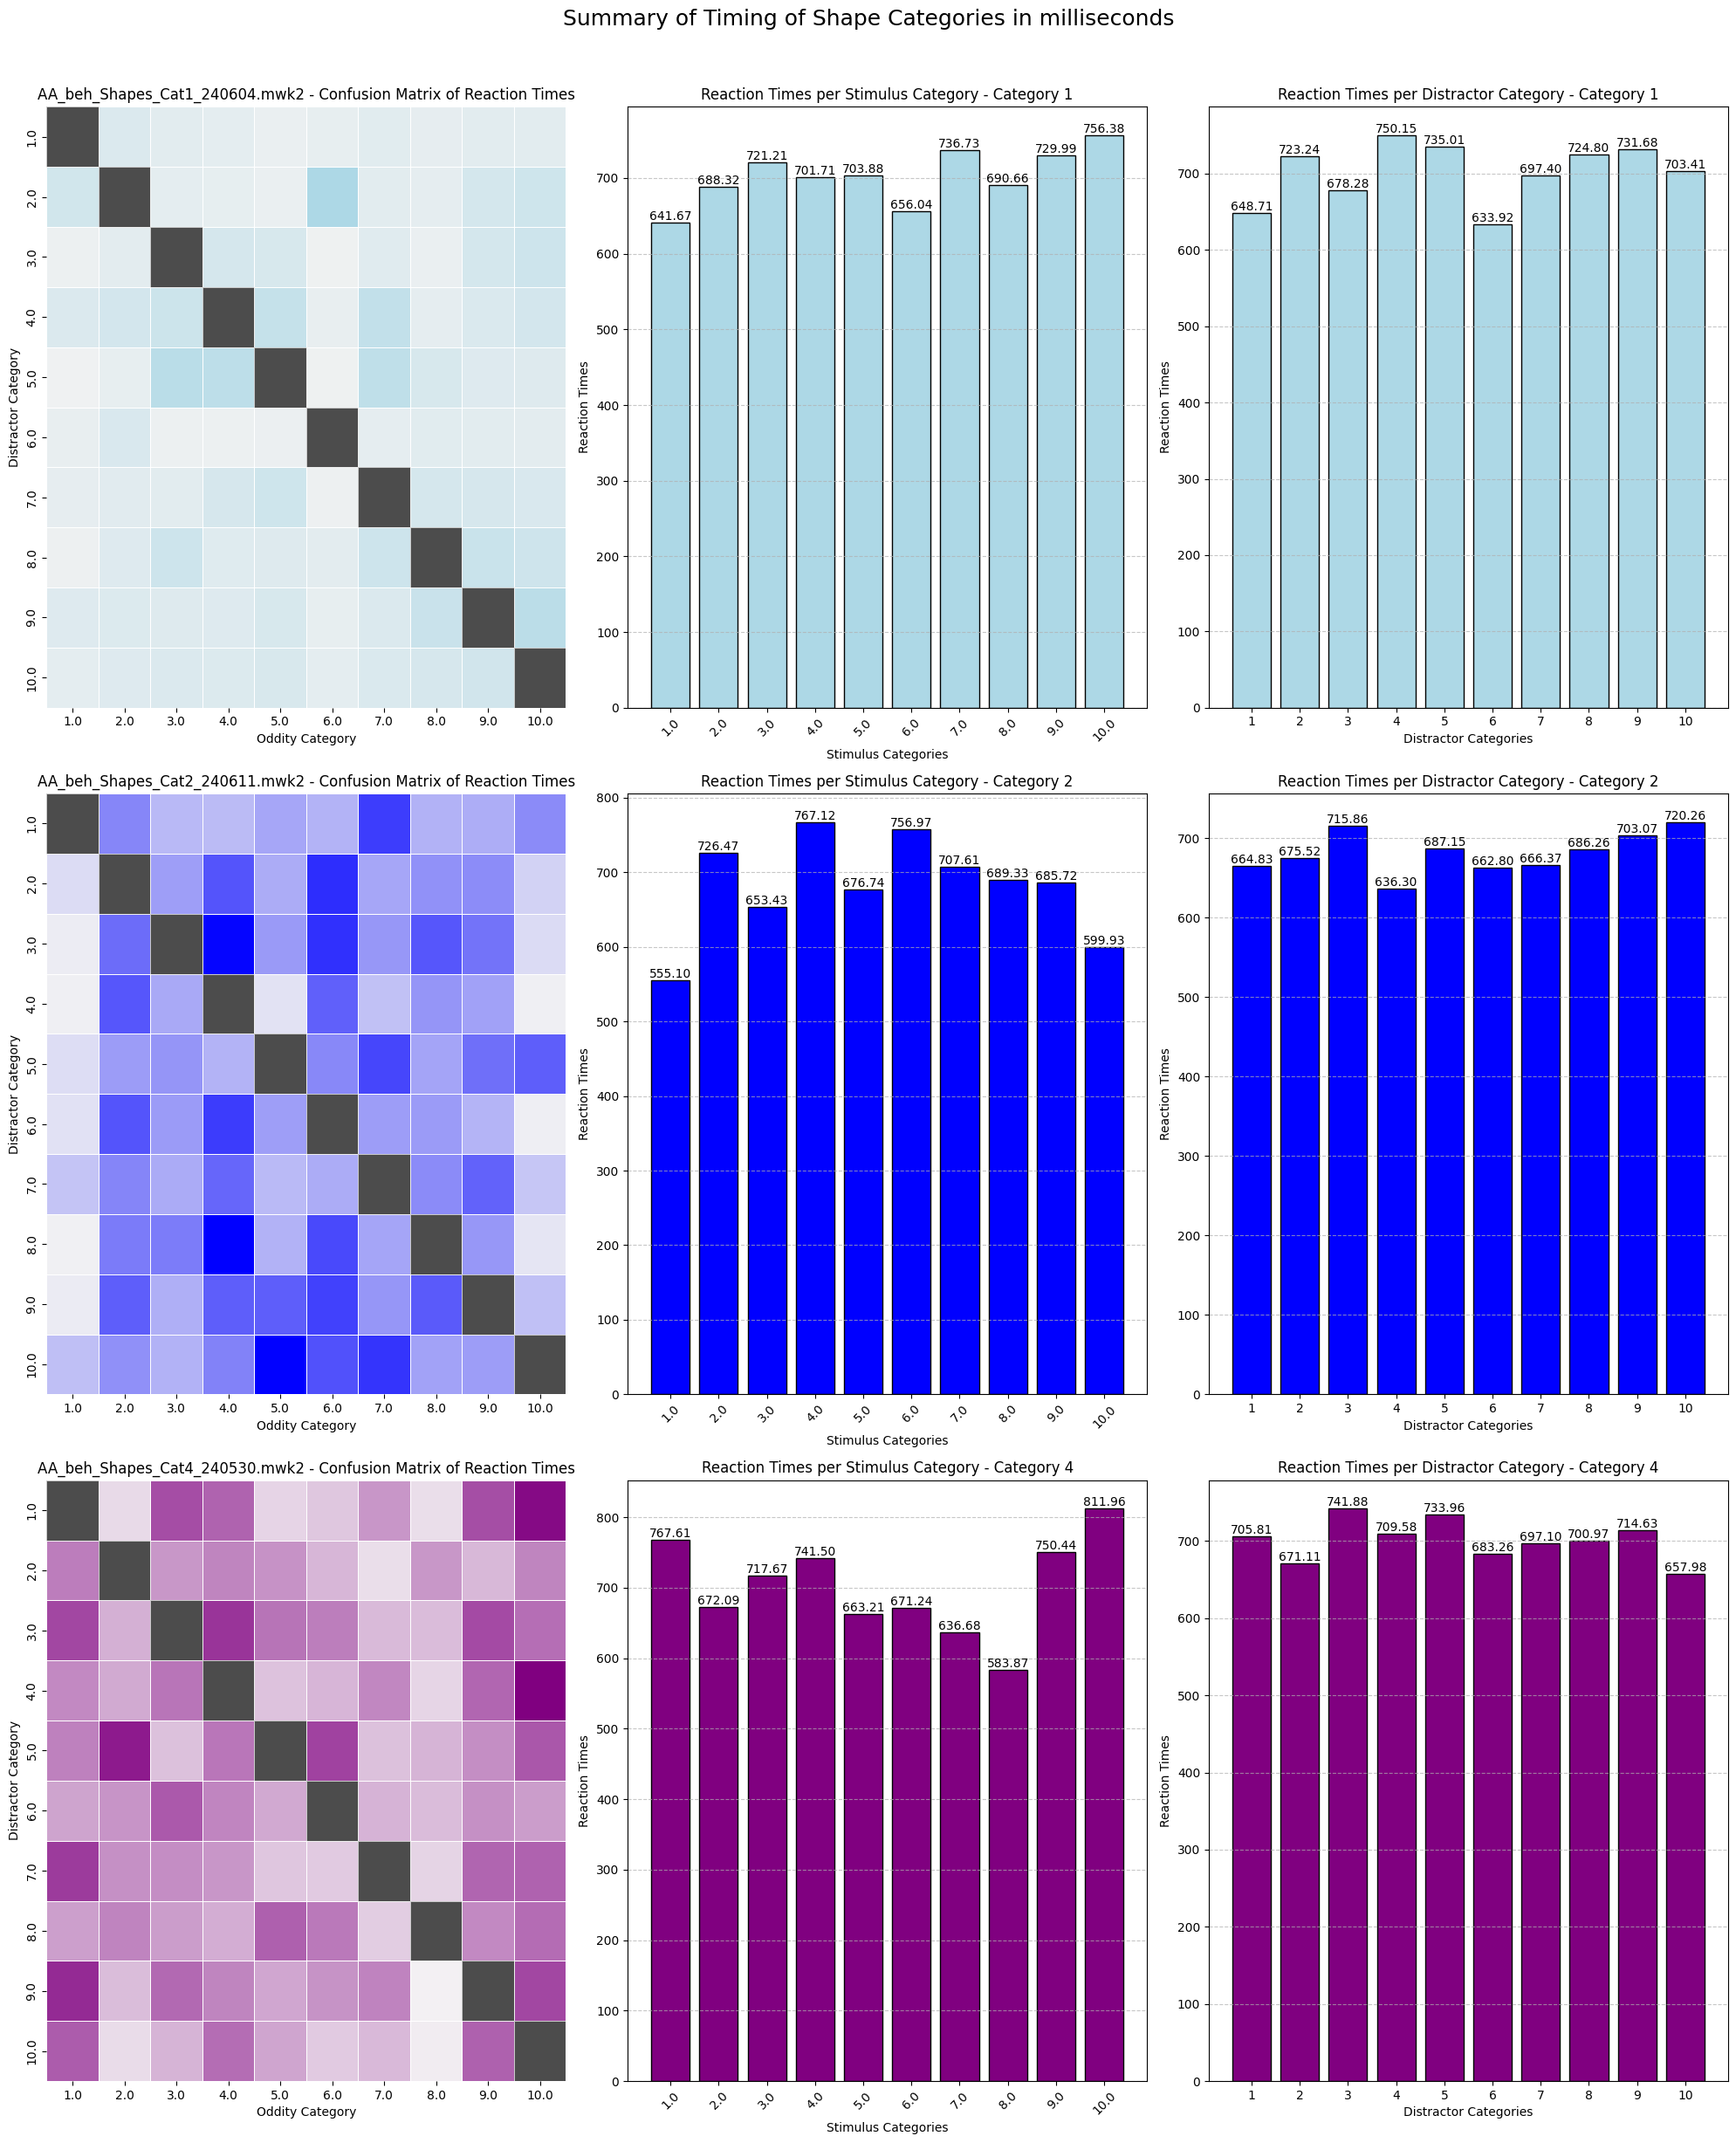

In [82]:
import matplotlib.colors as mcolors


fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 25))  # Adjust figure size as needed
row_colors = ['lightblue', 'blue', 'purple', 'green']
# Loop over each category and plot in the respective row
for i,(key, value) in enumerate(cat_dict_times.items()):
    # Create a DataFrame for the current category (assume stim_dict is organized by category)
    df = pd.DataFrame(value)  # Modify this based on your data structure

    ## CONFUSION MATRIX PLOT ******************************
    mask = df.isna()
    heatmap_color = sns.light_palette(row_colors[i], as_cmap=True)

    #cmap = sns.color_palette(row_colors[i], as_cmap=True)

    # Plot the heatmap on the first column (i-th row, first column)
    sns.heatmap(df, annot=False, cmap=heatmap_color, fmt=".2f", linewidths=.5, mask=mask, cbar=False, ax=axes[i, 0])

    # Overlay the NaN cells with black
    sns.heatmap(mask, mask=~mask, cmap=['black'], cbar=False, linewidths=.5, ax=axes[i, 0], alpha=0.7)

    # Set titles and labels for the confusion matrix
    axes[i, 0].set_title(f'{list_filename[i]} - Confusion Matrix of Reaction Times')
    axes[i, 0].set_xlabel('Oddity Category')
    axes[i, 0].set_ylabel('Distractor Category')

    ## MARGINAL 1 STIMULUS PLOT ******************************
    oddity_avg = df.mean(axis=0)
    x_labels = oddity_avg.index.astype(str)

    # Plot the averages as a bar graph on the second column (i-th row, second column)
    bars = axes[i, 1].bar(x_labels, oddity_avg, color=row_colors[i], edgecolor='black')

    # Add labels at the top of each bar
    for bar in bars:
        yval = bar.get_height()
        axes[i, 1].text(bar.get_x() + bar.get_width() / 2, yval, f'{yval:.2f}', ha='center', va='bottom', color='black')

    axes[i, 1].set_xlabel('Stimulus Categories')
    axes[i, 1].set_ylabel('Reaction Times')
    axes[i, 1].set_title(f'Reaction Times per Stimulus Category - Category {key}')
    axes[i, 1].grid(axis='y', linestyle='--', alpha=0.7)
    axes[i, 1].tick_params(axis='x', rotation=45)

    ## MARGINAL 2 DISTRACTOR PLOT ******************************
    df['distractorAvg'] = df.mean(axis=1)

    # Plot the averages as a bar graph on the third column (i-th row, third column)
    bars = axes[i, 2].bar(df.index, df['distractorAvg'], color=row_colors[i], edgecolor='black')

    for bar in bars:
        yval = bar.get_height()
        axes[i, 2].text(bar.get_x() + bar.get_width() / 2, yval, f'{yval:.2f}', ha='center', va='bottom', color='black')

    axes[i, 2].set_xlabel('Distractor Categories')
    axes[i, 2].set_ylabel('Reaction Times')
    axes[i, 2].set_title(f'Reaction Times per Distractor Category - Category {key}')
    axes[i, 2].grid(axis='y', linestyle='--', alpha=0.7)
    axes[i, 2].set_xticks(df.index)

# Adjust layout to prevent overlap and display the full figure
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout with space for suptitle
plt.suptitle('Summary of Timing of Shape Categories in milliseconds', fontsize=18)
fig = plt.gcf() 
plt.savefig('/home/tiffany/mwk_behavior/notebooks/figures/AA_summary_times.eps', format='eps')
plt.show()

#### Summary Statistics

In [86]:
cat_dict_nobg_nojf, cat_dict_times_nobg_nojf = makeDict(files_nobg_nojf)
cat_dict_bg_nojf, cat_dict_times_bg_nojf = makeDict(files_bg_nojf)
cat_dict_bg_jf8, cat_dict_times_bg_jf8 = makeDict(files_bg_jf8)
cat_dict_bg_jf16, cat_dict_times_bg_jf16 = makeDict(files_bg_jf16)

file exists AA_beh_Shapes_Cat1_240604.mwk2
category: 1
file exists AA_beh_Shapes_Cat2_240611.mwk2
category: 2
file exists AA_beh_Shapes_Cat4_240530.mwk2
category: 4
file exists AA_beh_Shapes_Cat1_bg_refresh_240711.mwk2
category: 1
file exists AA_beh_Shapes_Cat2_bg_refresh_240614.mwk2
category: 2
file exists AA_beh_Shapes_Cat4_bg_refresh_240621.mwk2
category: 4
file exists AA_beh_Shapes_Cat1_bg_refresh_jf8_240820.mwk2
category: 1
file exists AA_beh_Shapes_Cat2_bg_refresh_jf8_240821.mwk2
category: 2
file exists AA_beh_Shapes_Cat4_bg_refresh_jf8_240822.mwk2
category: 4
file exists AA_beh_Shapes_Cat1_bg_refresh_jf16_240903.mwk2
category: 1
file exists AA_beh_Shapes_Cat2_bg_refresh_jf16_240904.mwk2
category: 2
file exists AA_beh_Shapes_Cat4_bg_refresh_jf16_240905.mwk2
category: 4


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


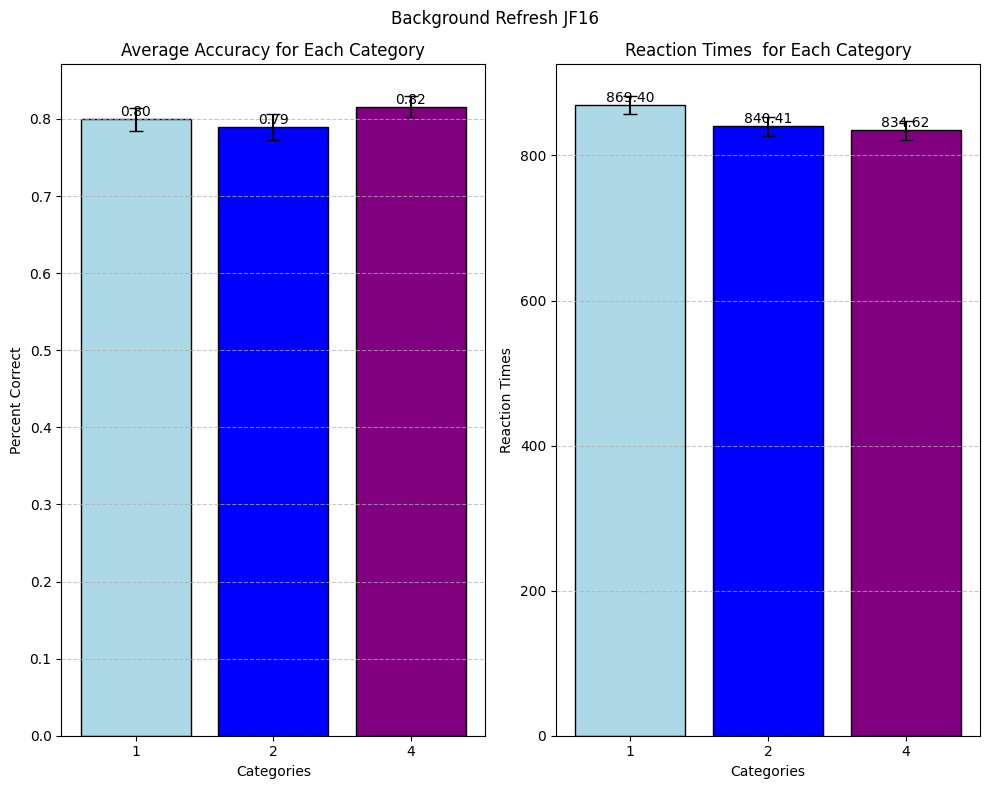

In [131]:
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 8))  # One plot for all categories

overall_avgs = []
overall_sems = []
categories = []
overall_times = []
overall_sems_times = []
categories_times = []

for i, (key, value) in enumerate(cat_dict_bg_jf16.items()):
    df = pd.DataFrame(value)
    
    ## MARGINAL 1 STIMULUS PLOT ******************************
    # Calculate the overall mean and standard error across all stimuli for each category
    overall_avg = df.mean(axis=0).mean()  # Mean across all stimuli (collapse)
    overall_sem = df.stack().sem()        # Standard error across all stimuli

    # Collect values for plotting
    overall_avgs.append(overall_avg)
    overall_sems.append(overall_sem)
    categories.append(key)

# Plot the overall averages as bars for each category on the first subplot (ax[0])
bars = ax[0].bar(categories, overall_avgs, yerr=overall_sems, capsize=5, color=[row_colors[i] for i in range(len(categories))], edgecolor='black')

# Add labels at the top of each bar
for bar in bars:
    yval = bar.get_height()
    ax[0].text(bar.get_x() + bar.get_width() / 2, yval, f'{yval:.2f}', ha='center', va='bottom', color='black')

# Set titles and labels for the first subplot
ax[0].set_xlabel('Categories')
ax[0].set_ylabel('Percent Correct')
ax[0].set_title('Average Accuracy for Each Category')
ax[0].grid(axis='y', linestyle='--', alpha=0.7)
ax[0].tick_params(axis='x')

# Loop for Reaction Times Plot (ax[1])
for i, (key, value) in enumerate(cat_dict_times_bg_jf16.items()):
    df = pd.DataFrame(value)
    
    ## MARGINAL 1 STIMULUS PLOT ******************************
    # Calculate the overall mean and standard error across all stimuli for each category
    overall_time = df.mean(axis=0).mean()  # Mean across all stimuli (collapse)
    overall_sem_time = df.stack().sem()        # Standard error across all stimuli

    # Collect values for plotting
    overall_times.append(overall_time)
    overall_sems_times.append(overall_sem_time)
    categories_times.append(key)

# Plot the overall averages as bars for each category on the second subplot (ax[1])
bars = ax[1].bar(categories_times, overall_times, yerr=overall_sems_times, capsize=5, color=[row_colors[i] for i in range(len(categories_times))], edgecolor='black')

# Add labels at the top of each bar
for bar in bars:
    yval = bar.get_height()
    ax[1].text(bar.get_x() + bar.get_width() / 2, yval, f'{yval:.2f}', ha='center', va='bottom', color='black')

# Set titles and labels for the second subplot
ax[1].set_xlabel('Categories')
ax[1].set_ylabel('Reaction Times')
ax[1].set_title('Reaction Times  for Each Category')
ax[1].grid(axis='y', linestyle='--', alpha=0.7)
ax[1].tick_params(axis='x')

fig.suptitle('Background Refresh JF16')

# Adjust layout and display the plot
plt.tight_layout()
fig = plt.gcf()
plt.savefig('/home/tiffany/mwk_behavior/notebooks/figures/AA_bg_JF16_by_cat.eps', format='eps')
plt.show()


need to- 
get one value for all 4 conditions- i guess overall % correct?
plot as a function of jitter

In [83]:
def makeDict(total_files):
    import re

    cat_dict = {}#nested dict, values will be stim dicts.
    cat_dict_times = {} #nested dict, values will be stim dict times
    list_filename = []
    for file in total_files:
        filename_mwk2 = file
        list_filename.append(filename_mwk2)
        #check that the file exists
        mwk2_filedir = '/v/awake_A2L/AA/mwk/'
        exfile_filepath = os.path.join(mwk2_filedir,filename_mwk2)
        if os.path.isfile(exfile_filepath):
            print(f'file exists {filename_mwk2}')
        else:
            print(f'Cannot find file {filename_mwk2}, are you sure it is there?')

        #extract the category number
        pattern = r"Cat(\d+)"
        match = re.search(pattern, filename_mwk2)
        shape_category = match.group(1)
        print(f'category: {shape_category}')

        relevant_codes_to_grab = ['#announceMessage','#stimDisplayUpdate','trial_bounds','target_angle','choice_locations','success','failure','oddity_category_index','distractor_category_index']
        parsed_file,_ = cp.parse_mwk2(exfile_filepath, codes = relevant_codes_to_grab)

        def extract_simple(parsed_file,code):
            dict = [x for x in parsed_file if code in str(x["code"])][0]
            times = np.asarray(dict["times"])
            values = np.asarray(dict["info"], dtype=object)
            return times,values
        times,values = extract_simple(parsed_file,'trial_bounds')

        #find values where start and stop are filled in with not -1s, those delimit completed trials
        trial_start = [x[0] for index,x in enumerate(values) if np.logical_and(x[0]!=-1,x[1]!=-1)]
        trial_end = [x[1] for index,x in enumerate(values) if np.logical_and(x[0]!=-1,x[1]!=-1)]

        #step 2, figure out which trials were successful and which were not successful.
        success_times,_ = extract_simple(parsed_file,'success')
        failure_times,_ = extract_simple(parsed_file,'failure')

        outcome = -1*np.ones(np.shape(trial_start))
        outcome_time = -1*np.ones(np.shape(trial_start))
        for index,(start,end) in enumerate(zip(trial_start,trial_end)):
            if np.any(np.logical_and(success_times>start,success_times<end)):
                outcome[index] = 1
                outcome_time[index] = success_times[np.logical_and(success_times>start,success_times<end)][0]
            elif np.any(np.logical_and(failure_times>start,failure_times<end)): 
                outcome[index] = 0
                outcome_time[index] = failure_times[np.logical_and(failure_times>start,failure_times<end)][0]
        #step 3, find which targets were looked at on successful and unsuccessful trials

        #step 3a, find the angle of the target on each trial
        target = -1*np.ones(np.shape(trial_start))
        targ_time,targ_val = extract_simple(parsed_file,'target_angle')
        for index,(start,end) in enumerate(zip(trial_start,trial_end)):
            if np.any(np.logical_and(targ_time>start,targ_time<end)):
                tmp = targ_val[np.logical_and(targ_time>start,targ_time<end)]
                target[index] = tmp[0]
        #step 3b, filter out all instances were all values are 0
        times,values = extract_simple(parsed_file,'choice_locations')
        filtered_values = [y for x, y in zip(times, values) if ~np.all(y == 0)]
        max_len = max(len(y) for y in filtered_values) #should be 11, all will be padded to 11
        padded_values = np.array([np.pad(y, (0, max_len - len(y)), mode='constant', constant_values=0) 
                          for y in filtered_values], dtype=object)
        mask = np.array([not all(x == 0 for x in lst) for lst in padded_values]) #bool mask to grab the needed incides
        times_sub = times[mask]
        values_sub = values[mask]
        choice = target.copy()
        for index,(start,end) in enumerate(zip(trial_start,trial_end)):
            if np.any(np.logical_and(times_sub>start,times_sub<end)):
                vals_unpad = values_sub[np.logical_and(times_sub>start,times_sub<end)]
                vals = np.array([np.pad(y, (0, max_len - len(y)), mode='constant', constant_values=0) 
                          for y in vals_unpad], dtype=object)
                vals2 = [x[np.logical_and(x!=0,x!=-1)] for x in vals]
        
        
                vals3 = [x for x in vals2 if any(x)]
        oddity = -1*np.ones(np.shape(trial_start))
        oddity_timing,oddity_index= extract_simple(parsed_file, 'oddity_category_index')
        for index,(start,end) in enumerate(zip(trial_start,trial_end)):
            if np.any(np.logical_and(oddity_timing>start,oddity_timing<end)):
                tmp = oddity_index[np.logical_and(oddity_timing>start,oddity_timing<end)]
                oddity[index] = tmp[0] +1 # need to add one since index 0
        
        distractor = -1*np.ones(np.shape(trial_start))
        distractor_timing,distractor_index = extract_simple(parsed_file, 'distractor_category_index')
        for index,(start,end) in enumerate(zip(trial_start,trial_end)):
            if np.any(np.logical_and(distractor_timing>start,distractor_timing<end)):
                tmp = distractor_index[np.logical_and(distractor_timing>start,distractor_timing<end)]
                distractor[index] = tmp[0]+1
 
        #our goal is to get filenames for images that are shown, the time at which things appeared on screen, and finally 
        stim_times,stim_vals = extract_simple(parsed_file,'#stimDisplayUpdate')

        file_store = []
        angle_store = []
        stim_on_time = -1*np.ones(np.shape(trial_start))
        for index,(start,end) in enumerate(zip(trial_start,trial_end)):

            #find times the stimulus on screen was updated during the trial
            curr_trial_times = stim_times[np.logical_and(stim_times>start,stim_times<end)] 
            curr_trial_stim = stim_vals[np.logical_and(stim_times>start,stim_times<end)]
    
            # find the instances most stuff was drawn to the screen and extract the stim and onset_time for that
            lens_disp = np.asarray([len(x) for x in curr_trial_stim])
            stim = curr_trial_stim[np.argmax(lens_disp)]
            onset_time = curr_trial_times[np.argmax(lens_disp)]
            stim_on_time[index] = onset_time
            #get file parameters
            stim2 = [x for x in stim if 'filename' in x]
            filenames = [x['filename'].split('/')[-1] for x in stim2]
            angles = [180*(1/np.pi)*np.arctan2(x['pos_y'],x['pos_x']) for x in stim2]
            angles2 = np.asarray([x if x>0 else x+360 for x in angles])

            #store everything
            file_store.append(filenames)
            angle_store.append(angles2)
        rt = [(x-y)/1000 if x!=-1 else -1 for x,y in zip(outcome_time,stim_on_time)] #reaction times
        stats = pd.DataFrame({'target':target,'choice':choice,'outcome':outcome,'oddity index':oddity,'distractor index':distractor})
        stats['rt'] = rt

        by_oddity_category = stats.groupby('oddity index')
        categories = by_oddity_category['oddity index'].unique()

        stim_dict = {}  # Create an empty dictionary
        stim_dict_times ={} #empty dictionary for timing
        # Step 1: Extract all unique distractor indices (as a list)
        all_distractor_indices = by_oddity_category['distractor index'].unique()
        # For each stimulus oddity category, go in and split it by distractor groups
        for stim_name, stim_data in by_oddity_category:
            distractor_groups = stim_data.groupby('distractor index')
            stim_dict[stim_name] = {}  # Creating a nested dictionary
            stim_dict_times[stim_name] ={} #create nested dictionary for the timing too

            if stim_name == 1.0:
                stim_dict[stim_name][1.0] = np.nan
                stim_dict_times[stim_name][1.0] = np.nan

            for distractor_name, distractor_data in distractor_groups:
                outcomes = distractor_data['outcome']
                non_aborted_outcomes = outcomes[outcomes != -1] 
                #this ensures that the percent correct is taken from all non aborted trials
                mean_outcome = non_aborted_outcomes.mean()
                stim_dict[stim_name][distractor_name] = mean_outcome

                #timing section now
                #only want timing for correct trials!
                correct_trials = distractor_data[distractor_data['outcome'] == 1]
                if not correct_trials.empty:  # If there are correct trials
                    mean_timing = correct_trials['rt'].mean()
                    stim_dict_times[stim_name][distractor_name] = mean_timing
                else:
                    stim_dict_times[stim_name][distractor_name] = np.nan  # No correct trials, set to NaN


        total_trials = (stats['outcome'] != -1).sum()
        cat_dict[shape_category] = stim_dict
        cat_dict_times[shape_category] = stim_dict_times
        
    return cat_dict, cat_dict_times
    

In [85]:
#gather list of file names
files_nobg_nojf = ['AA_beh_Shapes_Cat1_240604.mwk2', 'AA_beh_Shapes_Cat2_240611.mwk2', 'AA_beh_Shapes_Cat4_240530.mwk2']

files_bg_nojf = ['AA_beh_Shapes_Cat1_bg_refresh_240711.mwk2', 'AA_beh_Shapes_Cat2_bg_refresh_240614.mwk2', 'AA_beh_Shapes_Cat4_bg_refresh_240621.mwk2']


files_bg_jf8 = ['AA_beh_Shapes_Cat1_bg_refresh_jf8_240820.mwk2', 'AA_beh_Shapes_Cat2_bg_refresh_jf8_240821.mwk2', 'AA_beh_Shapes_Cat4_bg_refresh_jf8_240822.mwk2']

files_bg_jf16 = ['AA_beh_Shapes_Cat1_bg_refresh_jf16_240903.mwk2', 'AA_beh_Shapes_Cat2_bg_refresh_jf16_240904.mwk2', 'AA_beh_Shapes_Cat4_bg_refresh_jf16_240905.mwk2']


cat_dict_nobg_nojf, cat_dict_times_nobg_nojf = makeDict(files_nobg_nojf)
cat_dict_bg_nojf, cat_dict_times_bg_nojf = makeDict(files_bg_nojf)
cat_dict_bg_jf8, cat_dict_times_bg_jf8 = makeDict(files_bg_jf8)
cat_dict_bg_jf16, cat_dict_times_bg_jf16 = makeDict(files_bg_jf16)

file exists AA_beh_Shapes_Cat1_240604.mwk2
category: 1
file exists AA_beh_Shapes_Cat2_240611.mwk2
category: 2
file exists AA_beh_Shapes_Cat4_240530.mwk2
category: 4
file exists AA_beh_Shapes_Cat1_bg_refresh_240711.mwk2
category: 1
file exists AA_beh_Shapes_Cat2_bg_refresh_240614.mwk2
category: 2
file exists AA_beh_Shapes_Cat4_bg_refresh_240621.mwk2
category: 4
file exists AA_beh_Shapes_Cat1_bg_refresh_jf8_240820.mwk2
category: 1
file exists AA_beh_Shapes_Cat2_bg_refresh_jf8_240821.mwk2
category: 2
file exists AA_beh_Shapes_Cat4_bg_refresh_jf8_240822.mwk2
category: 4
file exists AA_beh_Shapes_Cat1_bg_refresh_jf16_240903.mwk2
category: 1
file exists AA_beh_Shapes_Cat2_bg_refresh_jf16_240904.mwk2
category: 2
file exists AA_beh_Shapes_Cat4_bg_refresh_jf16_240905.mwk2
category: 4


In [92]:
acc_list = [cat_dict_nobg_nojf, cat_dict_bg_nojf, cat_dict_bg_jf8, cat_dict_bg_jf16]
time_list = [cat_dict_times_nobg_nojf, cat_dict_times_bg_nojf, cat_dict_times_bg_jf8, cat_dict_times_bg_jf16]

Need to make sure I am making one cat dict for each category

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


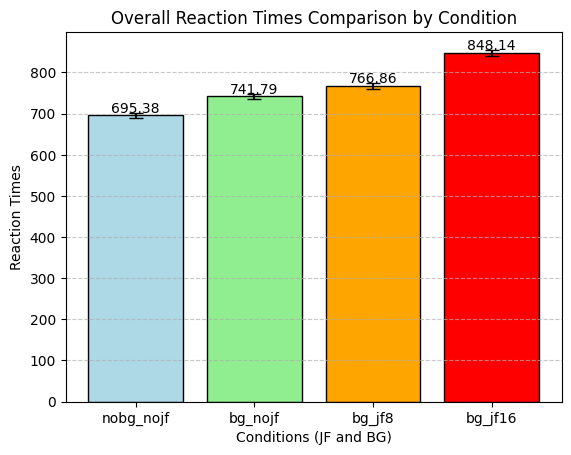

In [93]:
# Initialize lists to store the results
overall_avgs = []
overall_sems = []
labels = ['nobg_nojf', 'bg_nojf', 'bg_jf8', 'bg_jf16']

# Loop through each dictionary in acc_list
for i, cat_dict in enumerate(time_list):
    all_data = []  # Reset for each condition
    
    # Loop through the categories within the current dictionary
    for key, value in cat_dict.items():
        df = pd.DataFrame(value)
        all_data.append(df)

    # Concatenate all the dataframes for the current condition
    combined_df = pd.concat(all_data, axis=0)

    # Calculate the overall mean and standard error for the current condition
    overall_avg = combined_df.mean(axis=0).mean()  # Mean across all data
    overall_sem = combined_df.stack().sem()        # Standard error across all data

    # Collect values for plotting
    overall_avgs.append(overall_avg)
    overall_sems.append(overall_sem)
fig, ax = plt.subplots()
# Now plot the overall averages as bars for each condition
bars = ax.bar(labels, overall_avgs, yerr=overall_sems, capsize=5, color=['lightblue', 'lightgreen', 'orange', 'red'], edgecolor='black')

# Add labels at the top of each bar
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, yval, f'{yval:.2f}', ha='center', va='bottom', color='black')

# Set titles and labels for the plot
ax.set_xlabel('Conditions (JF and BG)')
ax.set_ylabel('Reaction Times')
ax.set_title('Overall Reaction Times Comparison by Condition')
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.tick_params(axis='x')

# Show the plot

fig = plt.gcf()
plt.savefig('/home/tiffany/mwk_behavior/notebooks/figures/AA_Overall_RT_by_Condition.eps', format='eps')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


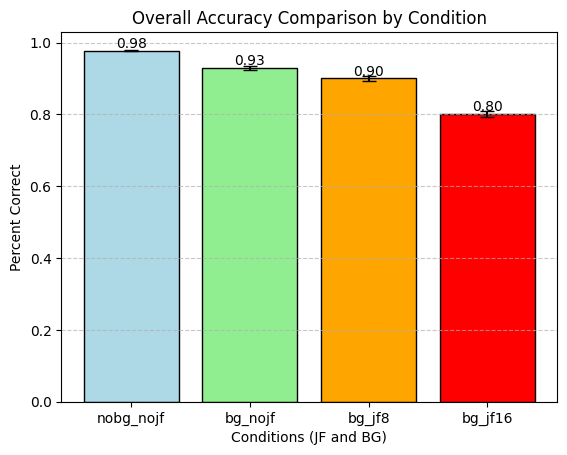

In [97]:
# Initialize lists to store the results
overall_avgs = []
overall_sems = []
labels = ['nobg_nojf', 'bg_nojf', 'bg_jf8', 'bg_jf16']

# Loop through each dictionary in acc_list
for i, cat_dict in enumerate(acc_list):
    all_data = []  # Reset for each condition
    
    # Loop through the categories within the current dictionary
    for key, value in cat_dict.items():
        df = pd.DataFrame(value)
        all_data.append(df)

    # Concatenate all the dataframes for the current condition
    combined_df = pd.concat(all_data, axis=0)

    # Calculate the overall mean and standard error for the current condition
    overall_avg = combined_df.mean(axis=0).mean()  # Mean across all data
    overall_sem = combined_df.stack().sem()        # Standard error across all data

    # Collect values for plotting
    overall_avgs.append(overall_avg)
    overall_sems.append(overall_sem)
fig, ax = plt.subplots()
# Now plot the overall averages as bars for each condition
bars = ax.bar(labels, overall_avgs, yerr=overall_sems, capsize=5, color=['lightblue', 'lightgreen', 'orange', 'red'], edgecolor='black')

# Add labels at the top of each bar
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, yval, f'{yval:.2f}', ha='center', va='bottom', color='black')

# Set titles and labels for the plot
ax.set_xlabel('Conditions (JF and BG)')
ax.set_ylabel('Percent Correct')
ax.set_title('Overall Accuracy Comparison by Condition')
ax.grid(axis='y', linestyle='--', alpha=0.7)
ax.tick_params(axis='x')

# Show the plot

fig = plt.gcf()  # This gets the current figure
plt.savefig('/home/tiffany/mwk_behavior/notebooks/figures/AA_Overall_Accuracy_by_Condition.eps', format='eps')
plt.show()

more plotting code:

[{'1': {1.0: {1.0: nan,
    2.0: 0.9523809523809523,
    3.0: 1.0,
    4.0: 0.9,
    5.0: 1.0,
    6.0: 1.0,
    7.0: 1.0,
    8.0: 1.0,
    9.0: 1.0,
    10.0: 1.0},
   2.0: {1.0: 0.9,
    3.0: 1.0,
    4.0: 0.9285714285714286,
    5.0: 1.0,
    6.0: 0.875,
    7.0: 0.9090909090909091,
    8.0: 1.0,
    9.0: 0.9411764705882353,
    10.0: 1.0},
   3.0: {1.0: 1.0,
    2.0: 1.0,
    4.0: 1.0,
    5.0: 1.0,
    6.0: 1.0,
    7.0: 0.8888888888888888,
    8.0: 0.96,
    9.0: 0.95,
    10.0: 1.0},
   4.0: {1.0: 0.9230769230769231,
    2.0: 0.9375,
    3.0: 1.0,
    5.0: 0.9444444444444444,
    6.0: 1.0,
    7.0: 1.0,
    8.0: 1.0,
    9.0: 1.0,
    10.0: 0.9375},
   5.0: {1.0: 1.0,
    2.0: 1.0,
    3.0: 0.9333333333333333,
    4.0: 0.95,
    6.0: 1.0,
    7.0: 0.8235294117647058,
    8.0: 1.0,
    9.0: 1.0,
    10.0: 1.0},
   6.0: {1.0: 1.0,
    2.0: 0.9230769230769231,
    3.0: 1.0,
    4.0: 1.0,
    5.0: 1.0,
    7.0: 0.95,
    8.0: 0.9473684210526315,
    9.0: 1.0,
    10.0: 0.9166666666

Processing condition 0
Processing condition 1
Processing condition 2
Processing condition 3


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


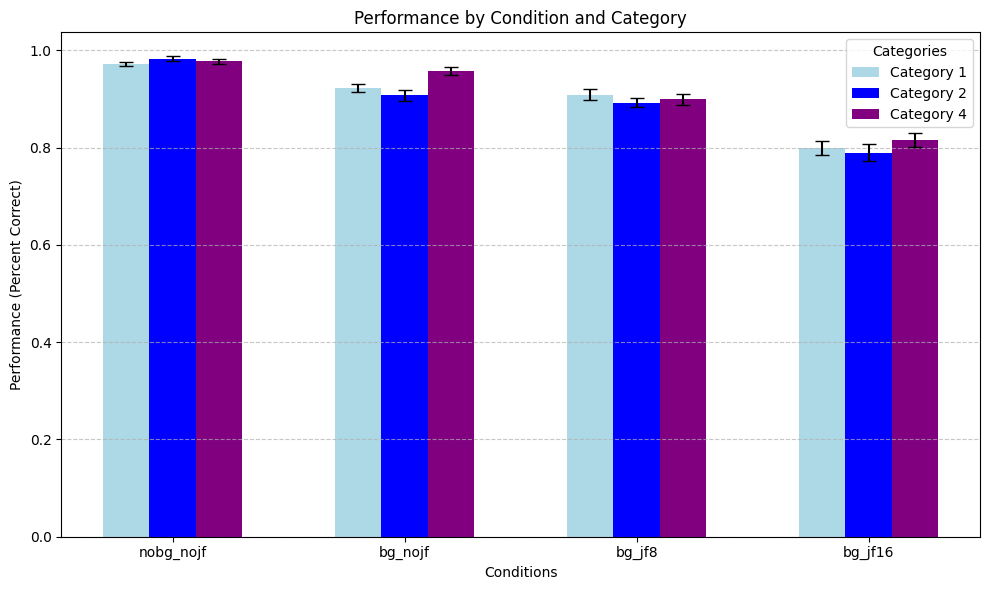

In [104]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Initialize lists to store the overall averages and standard errors for each condition
condition_avgs_all = []
condition_sems_all = []
categories = [1, 2, 4]  # The categories in each cat_dict
conditions = ['nobg_nojf', 'bg_nojf', 'bg_jf8', 'bg_jf16']  # Condition labels
# Define custom colors for each category
colors = ['lightblue', 'blue', 'purple']  # Adjust or add more colors if needed

# Loop through each dictionary in acc_list (each condition)
for condition, cat_dict in enumerate(acc_list):
    # Initialize lists for storing the averages and SEMs for the current condition
    condition_avgs = []
    condition_sems = []
    
    print(f"Processing condition {condition}")
    
    # Loop through the categories (1, 2, 4) within the current dictionary
    for category, data in cat_dict.items():
        df = pd.DataFrame(data)  # Convert data to DataFrame

        # Calculate the mean and standard error for the current category and condition
        overall_avg = df.mean(axis=0).mean()  # Mean across all stimuli
        overall_sem = df.stack().sem()        # Standard error across all stimuli

        # Collect values for plotting, organized by category
        condition_avgs.append(overall_avg)
        condition_sems.append(overall_sem)
    
    # Append the averages and SEMs for this condition to the overall lists
    condition_avgs_all.append(condition_avgs)
    condition_sems_all.append(condition_sems)

# Convert to numpy arrays for easier manipulation
condition_avgs_all = np.array(condition_avgs_all)
condition_sems_all = np.array(condition_sems_all)

# Now, create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Define the width of each bar
width = 0.2  # Adjust width for spacing between bars

# Set up the x locations for the groups (conditions)
x = np.arange(len(conditions))

# Plot bars for each category
for idx, cat in enumerate(categories):
    # Adjust x positions for each category group
    positions = x + (idx - 1) * width  # Center the bars for each category
    ax.bar(positions, condition_avgs_all[:, idx], width, yerr=condition_sems_all[:, idx], 
           capsize=5, color=colors[idx], label=f'Category {cat}')

# Set the x-axis labels and tick positions
ax.set_xticks(x)
ax.set_xticklabels(conditions)

# Set labels and title
ax.set_xlabel('Conditions')
ax.set_ylabel('Performance (Percent Correct)')
ax.set_title('Performance by Condition and Category')

# Add a legend
ax.legend(title='Categories')

# Add gridlines for clarity
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.tight_layout()

fig = plt.gcf()
plt.savefig('/home/tiffany/mwk_behavior/notebooks/figures/AA_performance_by_Condition.eps', format='eps')
plt.show()

Processing condition 0
Processing condition 1
Processing condition 2
Processing condition 3


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


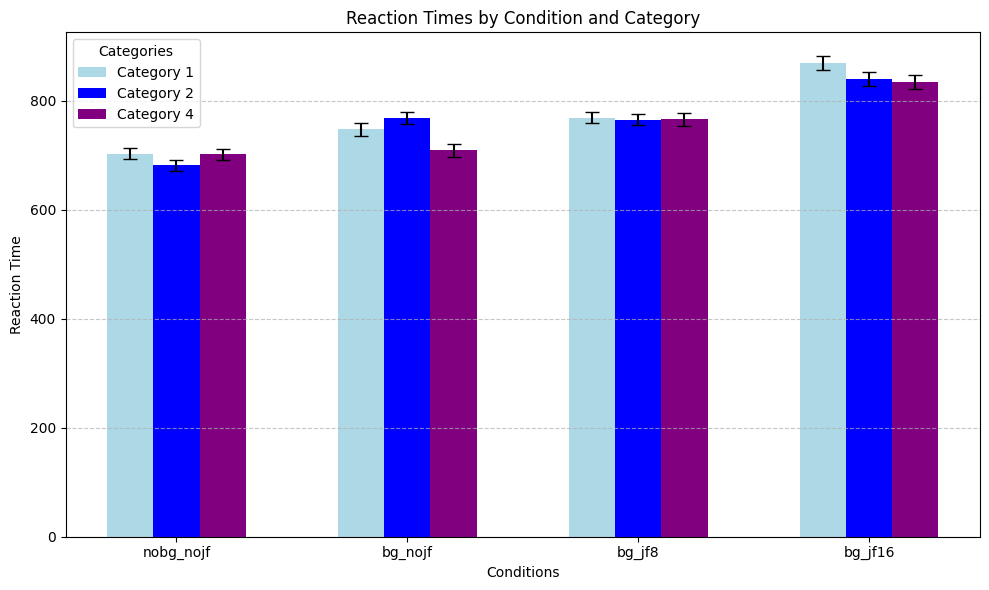

In [102]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Initialize lists to store the overall averages and standard errors for each condition
condition_avgs_all = []
condition_sems_all = []
categories = [1, 2, 4]  # The categories in each cat_dict
conditions = ['nobg_nojf', 'bg_nojf', 'bg_jf8', 'bg_jf16']  # Condition labels
# Define custom colors for each category
colors = ['lightblue', 'blue', 'purple']  # Adjust or add more colors if needed

# Loop through each dictionary in acc_list (each condition)
for condition, cat_dict in enumerate(time_list):
    # Initialize lists for storing the averages and SEMs for the current condition
    condition_avgs = []
    condition_sems = []
    
    print(f"Processing condition {condition}")
    
    # Loop through the categories (1, 2, 4) within the current dictionary
    for category, data in cat_dict.items():
        df = pd.DataFrame(data)  # Convert data to DataFrame

        # Calculate the mean and standard error for the current category and condition
        overall_avg = df.mean(axis=0).mean()  # Mean across all stimuli
        overall_sem = df.stack().sem()        # Standard error across all stimuli

        # Collect values for plotting, organized by category
        condition_avgs.append(overall_avg)
        condition_sems.append(overall_sem)
    
    # Append the averages and SEMs for this condition to the overall lists
    condition_avgs_all.append(condition_avgs)
    condition_sems_all.append(condition_sems)

# Convert to numpy arrays for easier manipulation
condition_avgs_all = np.array(condition_avgs_all)
condition_sems_all = np.array(condition_sems_all)

# Now, create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Define the width of each bar
width = 0.2  # Adjust width for spacing between bars

# Set up the x locations for the groups (conditions)
x = np.arange(len(conditions))

# Plot bars for each category
for idx, cat in enumerate(categories):
    # Adjust x positions for each category group
    positions = x + (idx - 1) * width  # Center the bars for each category
    ax.bar(positions, condition_avgs_all[:, idx], width, yerr=condition_sems_all[:, idx], 
           capsize=5, color=colors[idx], label=f'Category {cat}')

# Set the x-axis labels and tick positions
ax.set_xticks(x)
ax.set_xticklabels(conditions)

# Set labels and title
ax.set_xlabel('Conditions')
ax.set_ylabel('Reaction Time')
ax.set_title('Reaction Times by Condition and Category')

# Add a legend
ax.legend(title='Categories')

# Add gridlines for clarity
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.tight_layout()
fig = plt.gcf()
plt.savefig('/home/tiffany/mwk_behavior/notebooks/figures/AA_RT_by_Condition.eps', format='eps')
plt.show()

TTEST PVALUE CODE:

In [ ]:
cat_dict_nobg_nojf, cat_dict_times_nobg_nojf = makeDict(files_nobg_nojf)
cat_dict_bg_nojf, cat_dict_times_bg_nojf = makeDict(files_bg_nojf)
cat_dict_bg_jf8, cat_dict_times_bg_jf8 = makeDict(files_bg_jf8)
cat_dict_bg_jf16, cat_dict_times_bg_jf16 = makeDict(files_bg_jf16)

In [124]:
nobg_nojf_Shapes_avg = getAvg(cat_dict_nobg_nojf)
bg_nojf_Shapes_avg = getAvg(cat_dict_bg_nojf)

{'1': 1.0     0.983598
 2.0     0.950427
 3.0     0.977654
 4.0     0.971391
 5.0     0.967429
 6.0     0.970790
 7.0     0.949456
 8.0     1.000000
 9.0     0.972008
 10.0    0.980820
 dtype: float64,
 '2': 1.0     1.000000
 2.0     1.000000
 3.0     1.000000
 4.0     0.956658
 5.0     1.000000
 6.0     0.965586
 7.0     0.966374
 8.0     0.985450
 9.0     0.972856
 10.0    0.987291
 dtype: float64,
 '4': 1.0     0.935557
 2.0     0.982460
 3.0     0.985119
 4.0     0.972856
 5.0     1.000000
 6.0     0.983726
 7.0     0.985144
 8.0     0.992593
 9.0     0.968017
 10.0    0.968410
 dtype: float64}

{'1': 1.0     0.980710
 2.0     0.898647
 3.0     0.874844
 4.0     0.901243
 5.0     0.911848
 6.0     0.962038
 7.0     0.939062
 8.0     0.947258
 9.0     0.931471
 10.0    0.886705
 dtype: float64,
 '2': 1.0     0.935838
 2.0     0.915817
 3.0     0.873534
 4.0     0.908092
 5.0     0.893246
 6.0     0.871470
 7.0     0.950942
 8.0     0.897558
 9.0     0.917751
 10.0    0.916117
 dtype: float64,
 '4': 1.0     0.957492
 2.0     1.000000
 3.0     0.889815
 4.0     0.979630
 5.0     0.981481
 6.0     0.963664
 7.0     0.970238
 8.0     0.946689
 9.0     0.952020
 10.0    0.940476
 dtype: float64}

In [112]:
def getAvg(cat_dict):
    perShape_avg_Cat = {}
    for category, data in cat_dict.items():
        df = pd.DataFrame(data)
        shapeAvg = df.mean(axis = 0)
        perShape_avg_Cat[category] = shapeAvg
    display(perShape_avg_Cat)
    return(perShape_avg_Cat)


In [121]:
#for no background no jitter
cat1_shapesAvg = np.array(nobg_nojf_Shapes_avg['1'])
cat2_shapesAvg = np.array(nobg_nojf_Shapes_avg['2'])
cat4_shapesAvg = np.array(nobg_nojf_Shapes_avg['4'])
type(cat1_shapesAvg)

numpy.ndarray

In [123]:
from scipy import stats
print('No background no jitter \n')
t_stat, p_value = stats.ttest_ind(cat1_shapesAvg, cat4_shapesAvg)
print(f'Between cat 1 and 4, no bg no jf \n t_stat: {t_stat} p_value: {p_value} \n')

t_stat, p_value = stats.ttest_ind(cat2_shapesAvg, cat4_shapesAvg)
print(f'Between cat 2 and 4, no bg no jf \n t_stat: {t_stat} p_value: {p_value}')

No background no jitter 

Between cat 1 and 4, no bg no jf 
 t_stat: -0.6824852761168058 p_value: 0.5036213975084041 

Between cat 2 and 4, no bg no jf 
 t_stat: 0.7773029906147702 p_value: 0.4470762004350126


In [126]:
cat1_shapesAvg = np.array(bg_nojf_Shapes_avg['1'])
cat2_shapesAvg = np.array(bg_nojf_Shapes_avg['2'])
cat4_shapesAvg = np.array(bg_nojf_Shapes_avg['4'])

print('Background Refresh no jitter \n')
t_stat, p_value = stats.ttest_ind(cat1_shapesAvg, cat4_shapesAvg)
print(f'Between cat 1 and 4, bg no jf \n t_stat: {t_stat} p_value: {p_value} \n')

t_stat, p_value = stats.ttest_ind(cat2_shapesAvg, cat4_shapesAvg)
print(f'Between cat 2 and 4, bg no jf \n t_stat: {t_stat} p_value: {p_value}')

Background Refresh no jitter 

Between cat 1 and 4, bg no jf 
 t_stat: -2.4130854105713198 p_value: 0.02669942416464473 

Between cat 2 and 4, bg no jf 
 t_stat: -4.050701718698887 p_value: 0.0007501711533929115
